# **1. Introduction**

- Ant Colony Optimization (ACO) is a metaheuristic used for solving combinatorial optimization problems.
- ACO represents a class of algorithms that have been extensively researched.
- The first ACO algorithm, Ant System (AS), was proposed by Dorigo in 1992.
- This notebook provides a Python3 implementation of AS for the Travelling Salesman Problem (TSP).
- The implementation only uses numpy, matplotlib, and built-in functions.


# **2. Design**

**TSP**

- Symetric TSPs from TSPLIB with a little modification are used as the input.
- Each row in the input file consists of city index, x-coordinate, y-coordinate separated by a space
- Each row represents a city(node).
- A distance matrix between cities is computed based on these coordinates.

**Ant**

- Each ant could memorize neccessary information, interact with environment, and decide the direction for next move.
- Two lists of length n+1, n are used to store the tour and visited node (to avoid repeated visits.)
- tour_cost, the length of the tour, are dynamic computed during the tour construction.
- move() is the method contains the decision rule based on roulette selection algorithm. It simply traverse the choice_info matrix and decides the next node.
- nn_move() is modified from move() with enhancement by a nearest neighbour list nn_list, which brings a speed up when computing.

**AntSystemTSP**

- Details are in the implementation.
- Must recieve a dist matrix. Numpy ndarray is used instead of nested lists in python for a better performance.
- Stores all parameters used by AS.
- The choice_info matrix enable the reuse, which is the combination of the heuristic and pheromone information.
- nn_list is used for speed up when an ant decide where to go. nn_list[i][j] returns the index of i's j-th nearest neighbour.
- The output is a list of node index.

# **3. Implementation**

In [ ]:
import numpy as np
import random
import math
import logging
import time
import matplotlib.pyplot as plt

In [ ]:
class Ant:
    """A single ant with its own memory containing a reference to distance matrix,
    the tour and visited cities.
    """

    def __init__(self, n, dist):
        """Initilize an ant.

        Args:
            n (int): number of cities.
            dist (2-d nparray): the distance matrix between cities.
        """
        self.n = n
        self.dist = dist
        self.tour_cost = 0
        self.tour = [] # length n+1
        self.visited = [False] * n # length n

        start = random.randint(0, n-1)
        self.tour.append(start)
        self.visited[start] = True
    
    def visit(self, j):
        """Visit node j.

        Args:
            j (int): the node index.
        """
        i = self.tour[-1]
        self.tour.append(j)
        self.visited[j] = True
        self.tour_cost += self.dist[i, j]
    
    def reset(self):
        """Set all elements in visited to False.
        """
        self.tour_cost = 0
        self.tour = []
        self.visited = [False] * self.n

        start = random.randint(0, self.n-1)
        self.tour.append(start)
        self.visited[start] = True

    def move(self, choice_info):
        """move to next city according to AS desicion rule.

        Args:
            choice_info (2-d np array): a reference to the choice info array.
        """
        sum = 0
        i = self.tour[-1]
        selection_prob = [0] * self.n
        
        for j in range(self.n):
            if self.visited[j] == 0:
                selection_prob[j] = choice_info[i, j]
                sum += selection_prob[j]
        
        # roulette 
        r = random.uniform(0.0, sum)
        j = 0
        p = selection_prob[0]

        while p < r:
            j += 1
            p += selection_prob[j]
        
        self.visit(j)
    
    def _next_best(self, choice_info):
        """move to the node with maximum choice info.

        Args:
            choice_info (2-d np array): A reference to the choice info matrix.
        """
        i = self.tour[-1] # current node
        nc, v = None, 0 # next_city, max_choice_info_value
        for j in range(self.n):
            if not self.visited[j]:
                if choice_info[i, j] > v:
                    nc = j
                    v = choice_info[i, j]
        self.visit(nc)

    def nn_move(self, nn, nn_list, choice_info):
        """move to next according to a nearest neighbour AS decision rule.

        Args:
            nn (int): the length of the nn list.
            nn_list (2d list): a reference to the nearest neighbour list.
            choice_info (2d np array): the choice info matrix.
        """
        i = self.tour[-1] # current node
        selection_prob = [0] * nn
        sum = 0

        # move to nn first.
        for j in range(nn):
            if self.visited[nn_list[i][j]] == 0:
                selection_prob[j] = choice_info[i, nn_list[i][j]]
                sum += selection_prob[j]
        
        if sum == 0: # all node in nn list are visited.
            self._next_best()
        else: # roulette 
            r = random.uniform(0.0, sum)
            j = 0
            p = selection_prob[0]

            while p < r:
                j += 1
                p += selection_prob[j]
            # notice: j is not the index of the next node.
            # instead j means the next node is the j-th nearest neighbour.
            self.visit(nn_list[i][j])

In [ ]:
class AntSystemTSP:
    """The Ant System algorithm implementation for Symmetric TSP.
    """

    def __init__(self, dist, alpha=0.2, beta=5, rho=0.5, nn=None, tau_0=None, 
                 num_ants=None, max_iters=50, max_time=300):
        """Initilize AS for symmetrix TSP.

        Args:
            dist (2d np array): distance matrix of cities.
            alpha (float, optional): weight for pheromone. Defaults to 0.2.
            beta (int, optional): weight for eta. Defaults to 5.
            rho (float, optional): rate of evaporate. Defaults to 0.5.
            nn (int, optional): length of nearest neighbour list. Defaults to None.
            tau_0 (float, optional): initial pheromone trails. Defaults to 0.00001.
            num_ants (int, optional): the number of ants. Defaults to the number of nodes.
            max_iters (int, optional): maximum number of iterations. Defaults to 50.
            max_time (int, optional): maximum time for running. Defaults to 300.
        """
        self.n = len(dist)
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.num_ants = num_ants if num_ants else self.n
        self.tau_0 = tau_0 if tau_0 else 0.00001
        self.max_iters = max_iters
        self.max_time = max_time
        self.dist = np.copy(dist)
        
        dist[dist == 0] = 1e-8 # avoid divided by zero warning.
        self.eta = np.float_power(dist, -1)

        self.ants = []
        self._init_ants()

        self.pheromone = np.full((self.n, self.n), self.tau_0) # initialize trails.
        self.choice_info = np.empty((self.n, self.n))
        self.update_choice_info()

        self.best_tour = []
        self.min_cost = math.inf
        self.terminate = False

        self.nn = nn
        if self.nn:
            self.nn = nn
            self._init_nn_list()

    def _init_ants(self):
        self.ants = [Ant(self.n, self.dist) for i in range(self.num_ants)]
    
    def _init_nn_list(self):
        """Init the nearest neighbour lists. 
        """
        # nn_list(nearest neighbour list), nn_list[i][j] stores the index of the
        # j-th nearest node from node i.
        self.nn_list = [[]] * self.n
        dist = np.copy(self.dist)
        dist[dist == 0] = np.inf
        for i in range(self.n):
            l = list(dist[i])
            d = {idx:l[idx] for idx in range(self.n)}
            d_sorted = dict(sorted(d.items(), key=lambda item: item[1],
                            reverse=False))
            #print(d_sorted)
            self.nn_list[i] = list(d_sorted.keys())[:self.nn]
            #print(self.nn_list[i])

    def update_choice_info(self):
        self.choice_info = (np.float_power(self.pheromone, self.alpha) *
            np.float_power(self.eta, self.beta))
    
    def update_pheromone(self):

        # evaporate
        self.pheromone *= (1 - self.rho)

        # deposit
        for ant in self.ants:
            delta = 1 / ant.tour_cost
            for i in range(self.n - 1):
                j = i + 1
                self.pheromone[i, j] += delta
                self.pheromone[j, i] = self.pheromone[i, j]

        # update choice
        self.update_choice_info()
    
    def update_statistics(self):
        # find best solution.
        for ant in self.ants:
            if ant.tour_cost < self.min_cost:
                self.min_cost = ant.tour_cost
                self.best_tour = ant.tour
    
    def run(self):
        """Run the ACO(AS) algorithm on the TSP.
        """
        iter = 0
        start_time = time.time()

        while not self.terminate:
            iter += 1
            logging.info(f"Start iter: {iter}")

            # construct solutions
            for ant in self.ants:
                ant.reset()
            
            for ant in self.ants:
                for _ in range(self.n - 1):
                    if self.nn:
                        ant.nn_move(self.nn, self.nn_list, self.choice_info)
                    else:
                        ant.move(self.choice_info)
                ant.visit(ant.tour[0])
            # update statistics such as the best tour.
            self.update_statistics()

            # AS update pheromone after each iteration instead of each step.
            self.update_pheromone()

            # check for terminating
            cur_time = time.time()
            if cur_time - start_time >= self.max_time:
                self.terminate = True

            if iter >= self.max_iters:
                self.terminate = True
        
        end_time = time.time()
            
        print("-"*10)
        print(f"The best tour is\n {self.best_tour}\nwith cost {self.min_cost}.")
        print(f"Elapsed time: {end_time - start_time} s")
        print("-"*10)
        return self.best_tour, self.min_cost

----------
The best tour is
 [40, 21, 15, 2, 22, 13, 24, 12, 10, 11, 32, 45, 14, 39, 0, 8, 7, 37, 30, 43, 17, 6, 27, 35, 36, 18, 26, 16, 42, 29, 5, 19, 46, 20, 31, 38, 4, 47, 41, 25, 3, 34, 44, 9, 23, 28, 1, 33, 40]
with cost 37797.5058253962.
Elapsed time: 1.877079963684082 s
----------


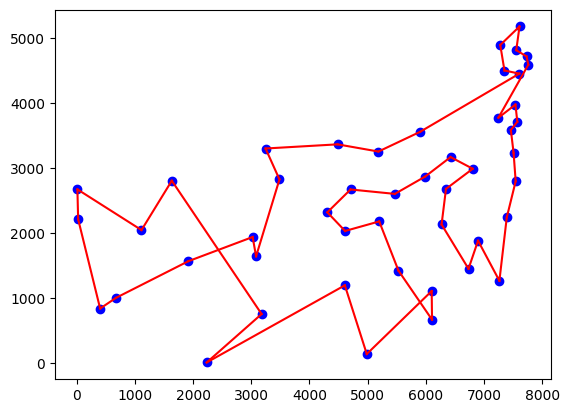

In [ ]:
# Test with a TSP

def plot_tour(city_x, city_y, tour):
    """Visualize the tour.

    Args:
        city_x (list): x-cordinates of all nodes.
        city_y (list): y-cordinates of all nodes.
        tour (list): the tour include both start and the end.
    """
    plt.scatter(city_x, city_y, marker="o", color="blue")

    for i in range(len(tour) - 1):
        j = i + 1
        x1, y1 = city_x[tour[i]], city_y[tour[i]]
        x2, y2 = city_x[tour[j]], city_y[tour[j]] 
        plt.plot([x1, x2], [y1, y2], color='red')

def main():
    input_file = '/content/att48.test.tsp'

    # Read input and compute dist matrix.
    X, Y= [], []
    with open(input_file) as f:
        for line in f.readlines():
            data = line.split(' ')
            X.append(int(data[1]))
            Y.append(int(data[2]))

    dist = np.ndarray((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            dist[i, j] = math.sqrt((X[i] - X[j])**2 + (Y[i] - Y[j])**2)
            dist[j, i] = dist[i, j]
            
    # Run the AS algorithm.
    as_tsp = AntSystemTSP(dist, max_iters=50, nn=48)
    tour, cost = as_tsp.run()
    plot_tour(X, Y, tour)

main()